# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`02`

* João Martins, 62532 - Hours worked on the project: 8
* Rúben Torres, 62531 - Hours worked on the project: 8
* Nuno Pereira, 56933 - Hours worked on the project: 8




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**



## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [4]:
### Your code Here
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from itertools import combinations

#'A0A024R1R8', 'A0A024RBG1', 'A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1'

human_proteins_dataset: dict = pickle.load(open("data_d3.pickle", "rb"))
# dataframe = pd.DataFrame(
#     list(human_proteins_dataset.items()), columns=["Id", "Proteome"]
# )


group_protein_sets = [
    set(human_proteins_dataset[protein]) for protein in human_proteins_dataset
]
# print(group_protein_sets[:20])

unique_proteins = sorted(
    set(protein for proteins in group_protein_sets for protein in proteins)
)
# print(unique_proteins)

protein_to_index = {protein: idx for idx, protein in enumerate(unique_proteins)}
# print(protein_to_index)


result_array = np.zeros((len(group_protein_sets), len(unique_proteins)), dtype=int)

for row_idx, proteins in enumerate(group_protein_sets):
    for protein in proteins:
        col_idx = protein_to_index[protein]
        result_array[row_idx, col_idx] = 1


## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [5]:
def MakeBucketsTs(TDocs, perms, N, B, R, M, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")          
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         
            i=0 
            while len(L)>0:
                elem=perm[i]                          
                docs_found=TDocs[elem] & L            
                if len(docs_found)>0:                 
                    SIGS[list(docs_found), r]=i       
                    L=L-docs_found                    
                i+=1                                  
                if i==M:                               
                    SIGS[list(L), r]=i                 
                    L={}

        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501, verbose=True):
    N,M=Data.shape
    if verbose:
        print("transpose the data set")
    DT=Data.T
    DataT=[set(np.where(DT[i]==1)[0]) for i in range(M)]
    P=B*R
    np.random.seed(3)
    if verbose:
        print(
            "Generating %d permutations for %6.3f similarity" % (P, (1 / B) ** (1 / R))
        )
    perms=[np.random.permutation(M) for i in range(P)]
    if verbose:
        print("Computing buckets...")
    buckets=MakeBucketsTs(DataT, perms, N, B, R, M, NB)
    return buckets

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc


def get_all_similar_docs(buckets):
    sim_docs = []
    for b, buck in buckets:
        if len(buckets[(b, buck)]) > 1:
            sim_docs += combinations(buckets[(b, buck)], 2)
    sim_docs = set(sim_docs)
    D = {}
    for i, j in sim_docs:
        D.setdefault(i, set()).add(j)
        D.setdefault(j, set()).add(i)
    return D

In [6]:
# Process the dataset

BANDS = 6
ROWS = 5

bucks = LSHT(result_array, BANDS, ROWS)
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])

transpose the data set
Generating 30 permutations for  0.699 similarity
Computing buckets...
Band 0 suggests these similar docs: {1, 17636}
Band 0 suggests these similar docs: {9, 100, 15}
Band 0 suggests these similar docs: {2930, 11}
Band 0 suggests these similar docs: {17, 2772}
Band 0 suggests these similar docs: {8194, 18948, 7173, 12808, 11790, 15886, 13842, 13843, 6677, 9240, 26, 2085, 2598, 5159, 552, 11301, 12325, 4139, 4150, 15926, 9785, 7738, 3131, 8250, 10298, 3647, 9281, 1091, 13893, 7751, 5206, 9815, 8282, 4187, 10843, 15964, 606, 14944, 1123, 4707, 18531, 11367, 14951, 7276, 6253, 3695, 17520, 15479, 15994, 14974, 18046, 8321, 13447, 14990, 9361, 5266, 3735, 3736, 7321, 10391, 16035, 7845, 17062, 7850, 8364, 1201, 19121, 1203, 7359, 10943, 3784, 18642, 1750, 7897, 4826, 9437, 16095, 2276, 15078, 7918, 4849, 14065, 4852, 2293, 8950, 5881, 11002, 5886, 8962, 7427, 4873, 15113, 15116, 7438, 5903, 5904, 7442, 1300, 10517, 10010, 18717, 4382, 2335, 14623, 4385, 8996, 4904, 59

In [7]:
######## MUST BE DELETED ########
sim_docs = get_all_similar_docs(bucks)

i = 57
for j in sim_docs[i]:
    print(
        "Documents %6d, and %6d, are %7.4f similar"
        % (i, j, JaccardSim(result_array[i], result_array[j]))
    )


Documents     57, and  14339, are  0.3203 similar
Documents     57, and   3076, are  0.2640 similar
Documents     57, and   9230, are  0.3072 similar
Documents     57, and  13847, are  0.3294 similar
Documents     57, and   9754, are  0.3417 similar
Documents     57, and   8219, are  0.3151 similar
Documents     57, and  10268, are  0.3094 similar
Documents     57, and  12318, are  0.3533 similar
Documents     57, and    549, are  0.2801 similar
Documents     57, and   1573, are  0.2937 similar
Documents     57, and  11816, are  0.3079 similar
Documents     57, and   2091, are  0.3041 similar
Documents     57, and   3117, are  0.3261 similar
Documents     57, and   9781, are  0.3065 similar
Documents     57, and   1589, are  0.2925 similar
Documents     57, and  15415, are  0.3675 similar
Documents     57, and  10298, are  0.3224 similar
Documents     57, and  18493, are  0.3412 similar
Documents     57, and   3135, are  0.3077 similar
Documents     57, and   9799, are  0.3488 similar


### Your short analysis here

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum


## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [8]:
### Add supporting functions here
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import csc_array


def plot_component_representation(X, Y, xlabel, ylabel) -> None:
    plt.plot(X, Y, label="SVD")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

U shape:  (19258, 19258)
[[-0.0015 -0.004   0.0056 ... -0.0045  0.0005  0.0032]
 [-0.0046 -0.0078  0.0033 ... -0.0074 -0.0078 -0.0046]
 [-0.0035 -0.0092 -0.0028 ... -0.0021  0.     -0.003 ]
 ...
 [-0.0033 -0.006  -0.     ...  0.9547  0.0015  0.0015]
 [-0.0029 -0.0054  0.0017 ...  0.0013  0.9622 -0.0013]
 [-0.0072 -0.009   0.0052 ...  0.0009 -0.0019  0.9429]]
S shape:  (2048,)
[1754.5155  276.0352  250.5838 ...    1.1901    1.1037    0.9285]
V shape:  (2048, 2048)
[[-0.0005 -0.0718 -0.0001 ... -0.0041 -0.0005 -0.0035]
 [ 0.0012 -0.102   0.0006 ...  0.0136  0.0007  0.0052]
 [-0.0017  0.0026  0.0002 ...  0.0108 -0.0027 -0.0001]
 ...
 [ 0.0012 -0.0001  0.0026 ...  0.0001  0.0009  0.0003]
 [-0.0001  0.0002  0.0009 ...  0.0006 -0.0004  0.0017]
 [ 0.0004 -0.      0.0006 ... -0.      0.0003 -0.0001]]


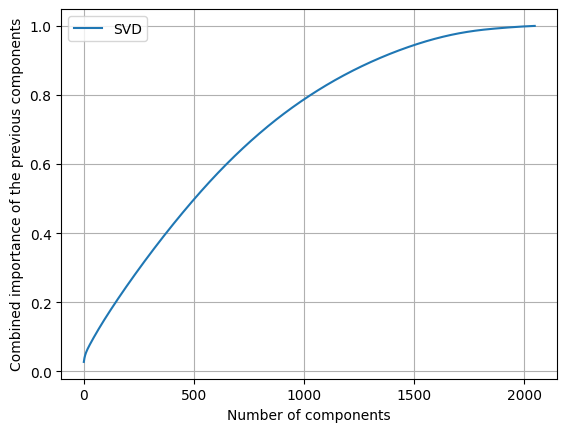

In [9]:
### Add processing code here
# print(result_array[:20,:20])

# # Step 5: Perform SVD
u, s, v = np.linalg.svd(result_array) 

# Print the results with specified print options
np.set_printoptions(precision=4, suppress=True)

print("U shape: ", u.shape)
print(u)
print("S shape: ", s.shape)
print(s)
print("V shape: ", v.shape)
print(v)

components_number = []
consept_representation = []
for i in range(len(s)):
    # print("first %d components have a combined importance of %7.4f" %(i+1, s[:i+1].sum()/s.sum()))
    components_number.append(i)
    consept_representation.append(s[: i + 1].sum() / s.sum())

plot_component_representation(
    components_number, 
    consept_representation,
    "Number of components",
    "Combined importance of the previous components",
)

In [10]:
S_csc=csc_array(result_array)

pca = TruncatedSVD(n_components=500)
pca.fit_transform(S_csc)
tve = 0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve += ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve))
print()
# print("Actual Eigenvalues:", pca.singular_values_)
for i, comp in enumerate(pca.components_):
    print("PC", i, "-->", comp)

PC0 - Variance explained:  0.0999 - Total Variance:  0.0999
PC1 - Variance explained:  0.0214 - Total Variance:  0.1213
PC2 - Variance explained:  0.0190 - Total Variance:  0.1403
PC3 - Variance explained:  0.0148 - Total Variance:  0.1551
PC4 - Variance explained:  0.0112 - Total Variance:  0.1662
PC5 - Variance explained:  0.0077 - Total Variance:  0.1739
PC6 - Variance explained:  0.0062 - Total Variance:  0.1801
PC7 - Variance explained:  0.0054 - Total Variance:  0.1855
PC8 - Variance explained:  0.0051 - Total Variance:  0.1906
PC9 - Variance explained:  0.0044 - Total Variance:  0.1950
PC10 - Variance explained:  0.0035 - Total Variance:  0.1985
PC11 - Variance explained:  0.0032 - Total Variance:  0.2017
PC12 - Variance explained:  0.0031 - Total Variance:  0.2048
PC13 - Variance explained:  0.0030 - Total Variance:  0.2078
PC14 - Variance explained:  0.0028 - Total Variance:  0.2106
PC15 - Variance explained:  0.0024 - Total Variance:  0.2130
PC16 - Variance explained:  0.0024

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
